In [1]:
import findspark
findspark.init()
findspark.find()

'C:\\spark-3.2.1-bin-hadoop3.2'

In [2]:
!pip3 install pyarrow

In [3]:
import duckdb
import numpy as np
import pandas as pd
import seaborn as sns
import pyspark
from pyspark.shell import spark
import pyarrow
#from pathlib import Path
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.pipeline import Pipeline
#from sklearn.metrics import f1_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'  # sharper plots
from pyspark.sql import functions as func
from pyspark.sql.types import ArrayType, FloatType, DecimalType, StringType, IntegerType
from pyspark.sql.functions import size
from pyspark.storagelevel import StorageLevel
from pyspark import SparkContext
from pyspark.sql.functions import col,when
from pyspark.sql import SparkSession
import os
 
# Optimizing Spark Conversion to Pandas https://arrow.apache.org/blog/2017/07/26/spark-arrow/
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", 1024)
%pip show pandas

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.2.1
      /_/

Using Python version 3.7.11 (default, Jul 27 2021 09:42:29)
Spark context Web UI available at http://host.docker.internal:4040
Spark context available as 'sc' (master = local[*], app id = local-1647898495224).
SparkSession available as 'spark'.
Name: pandasNote: you may need to restart the kernel to use updated packages.
Version: 1.3.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: c:\users\anton\anaconda3\envs\tensorflowkeras\lib\site-packages
Requires: pytz, python-dateutil, numpy
Required-by: seaborn, Mesa, ktrain, codecarbon



Reading Data

In [4]:
#Create PySpark SparkSession
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("IMDB") \
    .getOrCreate()

In [5]:
#Connecting with database
con = duckdb.connect(database='my-db.duckdb', read_only=False)

In [6]:
#First way
#getting dataframes and turning them into spark dfs
df1=spark.createDataFrame(con.execute("SELECT * FROM train_1").fetchdf())
df2=spark.createDataFrame(con.execute("SELECT * FROM train_2").fetchdf())
df3=spark.createDataFrame(con.execute("SELECT * FROM train_3").fetchdf())
df4=spark.createDataFrame(con.execute("SELECT * FROM train_4").fetchdf())
df5=spark.createDataFrame(con.execute("SELECT * FROM train_5").fetchdf())
df6=spark.createDataFrame(con.execute("SELECT * FROM train_6").fetchdf())
df7=spark.createDataFrame(con.execute("SELECT * FROM train_7").fetchdf())
df8=spark.createDataFrame(con.execute("SELECT * FROM train_8").fetchdf())
dfw=spark.createDataFrame(con.execute("SELECT * FROM writing").fetchdf())
dft=spark.createDataFrame(con.execute("SELECT * FROM test_hidden").fetchdf())
dfv=spark.createDataFrame(con.execute("SELECT * FROM validation_hidden").fetchdf())

In [7]:
#Second way
#first stacking/concating the dataframes and then turn them into spark df 
#(dont know which case is better 1 or 2)
df01 = con.execute("SELECT * FROM train_1").fetchdf()
df02 = con.execute("SELECT * FROM train_2").fetchdf()
df03 = con.execute("SELECT * FROM train_3").fetchdf()
df04 = con.execute("SELECT * FROM train_4").fetchdf()
df05 = con.execute("SELECT * FROM train_5").fetchdf()
df06 = con.execute("SELECT * FROM train_6").fetchdf()
df07 = con.execute("SELECT * FROM train_7").fetchdf()
df08 = con.execute("SELECT * FROM train_8").fetchdf()

df0 = pd.concat([df01,df02,df03,df04,df05,df06,df07,df08], axis = 0)
#sdf = spark.createDataFrame(df0) probably I need to provide my own schema the problem is different dtypes in orginalTitle
#we need to process them first and then concat them
df0
#should also merge writing df on tconst

,column0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label
0,4,tt0010600,The Doll,Die Puppe,1919,\N,66,1898.0,True
1,7,tt0011841,Way Down East,Way Down East,1920,\N,145,5376.0,True
2,9,tt0012494,Déstiny,Der müde Tod,1921,\N,97,5842.0,True
3,25,tt0015163,The Navigator,The Navigator,1924,\N,59,9652.0,True
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,\N,93,17887.0,True
...,...,...,...,...,...,...,...,...,...
988,9966,tt9625664,Trauma Center,NaN,2019,\N,87,12951.0,False
989,9981,tt9741310,Slaxx,Slaxx,2020,\N,77,2464.0,False
990,9982,tt9742392,Kindred,Kindred,2020,\N,101,1719.0,False
991,9996,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,NaN,2020,\N,111,4144.0,True


<AxesSubplot:ylabel='Frequency'>

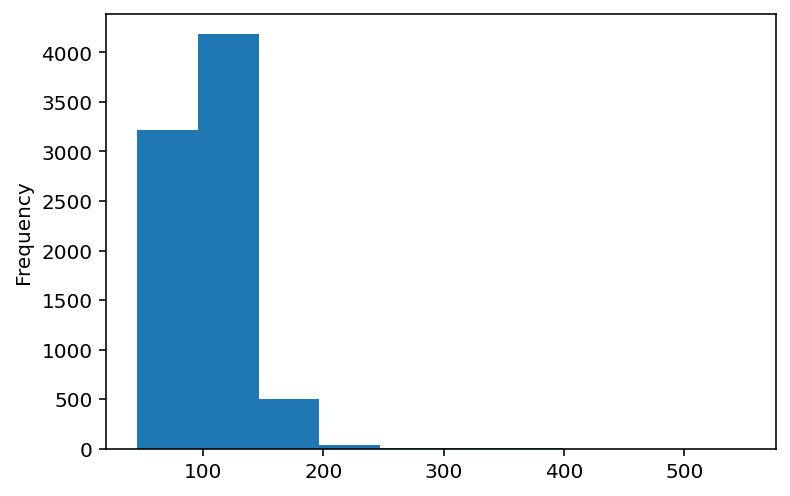

In [8]:
df0["runtimeMinutes"] = pd.to_numeric(df0["runtimeMinutes"],downcast='integer', errors = 'coerce')

df0.runtimeMinutes.plot.hist()


In [9]:
df0.tconst.duplicated().sum()

0

In [10]:
df0.drop_duplicates()

,column0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label
0,4,tt0010600,The Doll,Die Puppe,1919,\N,66.0,1898.0,True
1,7,tt0011841,Way Down East,Way Down East,1920,\N,145.0,5376.0,True
2,9,tt0012494,Déstiny,Der müde Tod,1921,\N,97.0,5842.0,True
3,25,tt0015163,The Navigator,The Navigator,1924,\N,59.0,9652.0,True
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,\N,93.0,17887.0,True
...,...,...,...,...,...,...,...,...,...
988,9966,tt9625664,Trauma Center,NaN,2019,\N,87.0,12951.0,False
989,9981,tt9741310,Slaxx,Slaxx,2020,\N,77.0,2464.0,False
990,9982,tt9742392,Kindred,Kindred,2020,\N,101.0,1719.0,False
991,9996,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,NaN,2020,\N,111.0,4144.0,True


In [11]:
df0["runtimeMinutes"] = pd.to_numeric(df0["runtimeMinutes"],downcast='integer', errors = 'coerce')

In [12]:
df0['primaryTitle'][df0["label"]==True].count()

3990

In [13]:
df0['primaryTitle'][df0["label"]==False].count() #balanced data

3969

In [14]:
#changing to numeric to be able to check correlation and to be able to turn the whole df to spark_df
df0["runtimeMinutes"] = pd.to_numeric(df0["runtimeMinutes"],downcast='integer', errors = 'coerce')


#correlation between columns providing info on what is usefull and what is not
#will perform this check for every new feature
df0.corr(method = 'spearman')

,column0,runtimeMinutes,numVotes,label
column0,1.000000,0.058717,-0.063430,-0.201733
runtimeMinutes,0.058717,1.000000,0.212816,0.335209
numVotes,-0.063430,0.212816,1.000000,0.225713
label,-0.201733,0.335209,0.225713,1.000000


In [15]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7959 entries, 0 to 992
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   column0         7959 non-null   int32  
 1   tconst          7959 non-null   object 
 2   primaryTitle    7959 non-null   object 
 3   originalTitle   3971 non-null   object 
 4   startYear       7959 non-null   object 
 5   endYear         7959 non-null   object 
 6   runtimeMinutes  7946 non-null   float64
 7   numVotes        7169 non-null   float64
 8   label           7959 non-null   bool   
dtypes: bool(1), float64(2), int32(1), object(5)
memory usage: 536.3+ KB


In [41]:
df00 = spark.createDataFrame(df0)
df00.show()
df00.count()

+-------+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|column0|   tconst|        primaryTitle|       originalTitle|startYear|endYear|runtimeMinutes|numVotes|label|
+-------+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|      4|tt0010600|            The Doll|           Die Puppe|     1919|     \N|          66.0|  1898.0| true|
|      7|tt0011841|       Way Down East|       Way Down East|     1920|     \N|         145.0|  5376.0| true|
|      9|tt0012494|             Déstiny|        Der müde Tod|     1921|     \N|          97.0|  5842.0| true|
|     25|tt0015163|       The Navigator|       The Navigator|     1924|     \N|          59.0|  9652.0| true|
|     38|tt0016220|The Phantom of th...|The Phantom of th...|     1925|     \N|          93.0| 17887.0| true|
|     42|tt0016630|     Báttling Bútlér|     Battling Butler|     1926|     \N|          77.0|  3285.0| true|
|     81|t

7959

In [18]:
df00.printSchema()

root
 |-- column0: integer (nullable = true)
 |-- tconst: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: double (nullable = true)
 |-- numVotes: double (nullable = true)
 |-- label: boolean (nullable = true)



In [42]:
train_df = df00
train_df = train_df.dropna(subset=["runtimeMinutes","numVotes"])
train_df.show()
train_df.count()

+-------+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|column0|   tconst|        primaryTitle|       originalTitle|startYear|endYear|runtimeMinutes|numVotes|label|
+-------+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|      4|tt0010600|            The Doll|           Die Puppe|     1919|     \N|          66.0|  1898.0| true|
|      7|tt0011841|       Way Down East|       Way Down East|     1920|     \N|         145.0|  5376.0| true|
|      9|tt0012494|             Déstiny|        Der müde Tod|     1921|     \N|          97.0|  5842.0| true|
|     25|tt0015163|       The Navigator|       The Navigator|     1924|     \N|          59.0|  9652.0| true|
|     38|tt0016220|The Phantom of th...|The Phantom of th...|     1925|     \N|          93.0| 17887.0| true|
|     42|tt0016630|     Báttling Bútlér|     Battling Butler|     1926|     \N|          77.0|  3285.0| true|
|     81|t

7157

In [36]:
train_df.toPandas()

,column0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label
0,4,tt0010600,The Doll,Die Puppe,1919,\N,66.0,1898.0,True
1,7,tt0011841,Way Down East,Way Down East,1920,\N,145.0,5376.0,True
2,9,tt0012494,Déstiny,Der müde Tod,1921,\N,97.0,5842.0,True
3,25,tt0015163,The Navigator,The Navigator,1924,\N,59.0,9652.0,True
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,\N,93.0,17887.0,True
...,...,...,...,...,...,...,...,...,...
7152,9966,tt9625664,Trauma Center,None,2019,\N,87.0,12951.0,False
7153,9981,tt9741310,Slaxx,Slaxx,2020,\N,77.0,2464.0,False
7154,9982,tt9742392,Kindred,Kindred,2020,\N,101.0,1719.0,False
7155,9996,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,None,2020,\N,111.0,4144.0,True


In [43]:
#Replace \N with 2022 in endyear
train_df = train_df.withColumn("endYear", when(train_df.endYear == "\\N","2022")
                                 .otherwise(train_df.endYear))

In [44]:
#Swap start and endyear
train_df = train_df.withColumn("startYear", when(train_df.startYear == "\\N", train_df.endYear)
                              .otherwise(train_df.startYear))

In [45]:
train_df = train_df.withColumn("endYear", when(train_df.endYear == train_df.startYear, "2022")
                              .otherwise(train_df.endYear))

In [46]:
#New feature: YearSinceRelease
train_df = train_df.withColumn('YearSinceRealease', ( train_df['endYear'] - train_df['startYear'] ))

In [48]:
train_df.show()
train_df.count()

+-------+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+-----------------+
|column0|   tconst|        primaryTitle|       originalTitle|startYear|endYear|runtimeMinutes|numVotes|label|YearSinceRealease|
+-------+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+-----------------+
|      4|tt0010600|            The Doll|           Die Puppe|     1919|   2022|          66.0|  1898.0| true|            103.0|
|      7|tt0011841|       Way Down East|       Way Down East|     1920|   2022|         145.0|  5376.0| true|            102.0|
|      9|tt0012494|             Déstiny|        Der müde Tod|     1921|   2022|          97.0|  5842.0| true|            101.0|
|     25|tt0015163|       The Navigator|       The Navigator|     1924|   2022|          59.0|  9652.0| true|             98.0|
|     38|tt0016220|The Phantom of th...|The Phantom of th...|     1925|   2022|          93.0| 17887.0| 

7157

In [49]:
train = train_df.toPandas()
train

,column0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label,YearSinceRealease
0,4,tt0010600,The Doll,Die Puppe,1919,2022,66.0,1898.0,True,103.0
1,7,tt0011841,Way Down East,Way Down East,1920,2022,145.0,5376.0,True,102.0
2,9,tt0012494,Déstiny,Der müde Tod,1921,2022,97.0,5842.0,True,101.0
3,25,tt0015163,The Navigator,The Navigator,1924,2022,59.0,9652.0,True,98.0
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,2022,93.0,17887.0,True,97.0
...,...,...,...,...,...,...,...,...,...,...
7152,9966,tt9625664,Trauma Center,None,2019,2022,87.0,12951.0,False,3.0
7153,9981,tt9741310,Slaxx,Slaxx,2020,2022,77.0,2464.0,False,2.0
7154,9982,tt9742392,Kindred,Kindred,2020,2022,101.0,1719.0,False,2.0
7155,9996,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,None,2020,2022,111.0,4144.0,True,2.0


In [57]:
train["startYear"] = pd.to_numeric(train["startYear"],downcast='integer', errors = 'coerce')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7157 entries, 0 to 7156
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   column0            7157 non-null   int32  
 1   tconst             7157 non-null   object 
 2   primaryTitle       7157 non-null   object 
 3   originalTitle      3565 non-null   object 
 4   startYear          7157 non-null   int16  
 5   endYear            7157 non-null   object 
 6   runtimeMinutes     7157 non-null   float64
 7   numVotes           7157 non-null   float64
 8   label              7157 non-null   bool   
 9   YearSinceRealease  7157 non-null   float64
dtypes: bool(1), float64(3), int16(1), int32(1), object(4)
memory usage: 440.4+ KB


<b>ML</b>

In [50]:
!pip3 install lightgbm

In [64]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

# To define the input and output feature
x = train.drop(['column0','tconst','primaryTitle','originalTitle', 'endYear',],axis=1)
x['runtimeMinutes'] = x['runtimeMinutes'].astype(float)
y = train['label']
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.10,random_state=42)

In [77]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(24,40,2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(x_train, y_train,
        eval_set = [(x_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.598001	valid_0's l1: 0.450089
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520215	valid_0's l1: 0.405606
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455348	valid_0's l1: 0.365772
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400516	valid_0's l1: 0.330025
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353677	valid_0's l1: 0.297897
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313327	valid_0's l1: 0.268989
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801	valid_0's l1: 0.450093
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520222	valid_0's l1: 0.40561
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455354	valid_0's l1: 0.365776
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400521	valid_0's l1: 0.330029
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353681	valid_0's l1: 0.297901
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313331	valid_0's l1: 0.268991
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801	valid_0's l1: 0.450093
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520222	valid_0's l1: 0.40561
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455354	valid_0's l1: 0.365776
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400521	valid_0's l1: 0.330029
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353681	valid_0's l1: 0.297901
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313331	valid_0's l1: 0.268991
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801	valid_0's l1: 0.450093
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520222	valid_0's l1: 0.40561
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455354	valid_0's l1: 0.365776
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400521	valid_0's l1: 0.330029
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353681	valid_0's l1: 0.297901
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313331	valid_0's l1: 0.268991
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801	v

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520222	valid_0's l1: 0.40561
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455354	valid_0's l1: 0.365776
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400521	valid_0's l1: 0.330029
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353681	valid_0's l1: 0.297901
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313331	valid_0's l1: 0.268991
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.598001	valid_0's l1: 0.450089
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520215	valid_0's l1: 0.405606
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455348	valid_0's l1: 0.365772
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400516	valid_0's l1: 0.330025
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353677	valid_0's l1: 0.297897
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313327	valid_0's l1: 0.268989
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801	valid_0's l1: 0.450093
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.52022

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520215	valid_0's l1: 0.405606
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455348	valid_0's l1: 0.365772
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400516	valid_0's l1: 0.330025
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353677	valid_0's l1: 0.297897
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313327	valid_0's l1: 0.268989
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801	valid_0's l1: 0.450093
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520222	valid_0's l1: 0.40561
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455354	valid_0's l1: 0.365776
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400521	valid_0's l1: 0.330029
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353681	valid_0's l1: 0.297901
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313331	valid_0's l1: 0.268991
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801	valid_0's l1: 0.450093
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520222

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801	valid_0's l1: 0.450093
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520222	valid_0's l1: 0.40561
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455354	valid_0's l1: 0.365776
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400521	valid_0's l1: 0.330029
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353681	valid_0's l1: 0.297901
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313331	valid_0's l1: 0.268991
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.59801	valid_0's l1: 0.450093
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.520222	valid_0's l1: 0.40561
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.455354	valid_0's l1: 0.365776
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.400521	valid_0's l1: 0.330029
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.353681	valid_0's l1: 0.297901
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.313331	valid_0's l1: 0.268991
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.598001	

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484509	valid_0's l1: 0.383999
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411373	valid_0's l1: 0.33726
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351653	valid_0's l1: 0.296475
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302187	valid_0's l1: 0.260799
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260766	valid_0's l1: 0.229538
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575817	valid_0's l1: 0.437753
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484509	valid_0's l1: 0.383999
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411373	valid_0's l1: 0.33726
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351653	valid_0's l1: 0.296475
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302187	valid_0's l1: 0.260799
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260766	valid_0's l1: 0.229538
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575817	valid_0's l1: 0.437753
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.48450

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484509	valid_0's l1: 0.383999
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411373	valid_0's l1: 0.33726
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351653	valid_0's l1: 0.296475
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302187	valid_0's l1: 0.260799
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260766	valid_0's l1: 0.229538
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575809	valid_0's l1: 0.437749
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484502	valid_0's l1: 0.383995
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411368	valid_0's l1: 0.337256
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351648	valid_0's l1: 0.296472
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302183	valid_0's l1: 0.260797
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260763	valid_0's l1: 0.229536
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575817	valid_0's l1: 0.437753
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.4845

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575817	valid_0's l1: 0.437753
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484509	valid_0's l1: 0.383999
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411373	valid_0's l1: 0.33726
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351653	valid_0's l1: 0.296475
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302187	valid_0's l1: 0.260799
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260766	valid_0's l1: 0.229538
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575817	valid_0's l1: 0.437753
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484509	valid_0's l1: 0.383999
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411373	valid_0's l1: 0.33726
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351653	valid_0's l1: 0.296475
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302187	valid_0's l1: 0.260799
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260766	valid_0's l1: 0.229538
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.57580

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484509	valid_0's l1: 0.383999
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411373	valid_0's l1: 0.33726
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351653	valid_0's l1: 0.296475
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302187	valid_0's l1: 0.260799
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260766	valid_0's l1: 0.229538
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575817	valid_0's l1: 0.437753
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484509	valid_0's l1: 0.383999
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411373	valid_0's l1: 0.33726
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351653	valid_0's l1: 0.296475
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302187	valid_0's l1: 0.260799
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260766	valid_0's l1: 0.229538
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575817	valid_0's l1: 0.437753
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.48450

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484509	valid_0's l1: 0.383999
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411373	valid_0's l1: 0.33726
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351653	valid_0's l1: 0.296475
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302187	valid_0's l1: 0.260799
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260766	valid_0's l1: 0.229538
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575809	valid_0's l1: 0.437749
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.484502	valid_0's l1: 0.383995
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.411368	valid_0's l1: 0.337256
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.351648	valid_0's l1: 0.296472
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.302183	valid_0's l1: 0.260797
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.260763	valid_0's l1: 0.229536
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.575817	valid_0's l1: 0.437753
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.4845

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	valid_0's l1: 0.363231
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372053	valid_0's l1: 0.310682
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309372	valid_0's l1: 0.266092
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258934	valid_0's l1: 0.228126
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217809	valid_0's l1: 0.195721
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.55424	valid_0's l1: 0.42549
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	valid_0's l1: 0.363231
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372053	valid_0's l1: 0.310682
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309372	valid_0's l1: 0.266092
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258934	valid_0's l1: 0.228126
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217809	valid_0's l1: 0.195721
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.55424	valid_0's l1: 0.42549
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451343	valid_0's l1: 0.363227
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372048	valid_0's l1: 0.310679
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309369	valid_0's l1: 0.26609
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258931	valid_0's l1: 0.228123
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217806	valid_0's l1: 0.195719
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.55424	valid_0's l1: 0.42549
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	valid_0's l1: 0.363231
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372053	valid_0's l1: 0.310682
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309372	valid_0's l1: 0.266092
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258934	valid_0's l1: 0.228126
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217809	valid_0's l1: 0.195721
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.55424	valid_0's l1: 0.42549
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	v

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	valid_0's l1: 0.363231
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372053	valid_0's l1: 0.310682
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309372	valid_0's l1: 0.266092
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258934	valid_0's l1: 0.228126
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217809	valid_0's l1: 0.195721
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.55424	valid_0's l1: 0.42549
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	valid_0's l1: 0.363231
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372053	valid_0's l1: 0.310682
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309372	valid_0's l1: 0.266092
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258934	valid_0's l1: 0.228126
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217809	valid_0's l1: 0.195721
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.554232	valid_0's l1: 0.425485
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.45134

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	valid_0's l1: 0.363231
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372053	valid_0's l1: 0.310682
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309372	valid_0's l1: 0.266092
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258934	valid_0's l1: 0.228126
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217809	valid_0's l1: 0.195721
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.55424	valid_0's l1: 0.42549
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	valid_0's l1: 0.363231
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372053	valid_0's l1: 0.310682
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309372	valid_0's l1: 0.266092
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258934	valid_0's l1: 0.228126
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217809	valid_0's l1: 0.195721
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.55424	valid_0's l1: 0.42549
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349	valid_0's l1: 0.363231
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372053	valid_0's l1: 0.310682
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309372	valid_0's l1: 0.266092
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258934	valid_0's l1: 0.228126
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217809	valid_0's l1: 0.195721
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.554232	valid_0's l1: 0.425485
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451343	valid_0's l1: 0.363227
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.372048	valid_0's l1: 0.310679
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.309369	valid_0's l1: 0.26609
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.258931	valid_0's l1: 0.228123
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.217806	valid_0's l1: 0.195719
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.55424	valid_0's l1: 0.42549
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.451349

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.420552	valid_0's l1: 0.343315
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.336828	valid_0's l1: 0.285968
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.272653	valid_0's l1: 0.238643
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.222406	valid_0's l1: 0.19941
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.182465	valid_0's l1: 0.166786
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.533273	valid_0's l1: 0.413317
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.420552	valid_0's l1: 0.343315
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.336828	valid_0's l1: 0.285968
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.272653	valid_0's l1: 0.238643
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.222406	valid_0's l1: 0.19941
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.182465	valid_0's l1: 0.166786
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.533273	valid_0's l1: 0.413317
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.42055

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.420546	valid_0's l1: 0.343311
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.336824	valid_0's l1: 0.285965
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.27265	valid_0's l1: 0.23864
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.222404	valid_0's l1: 0.199408
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.182463	valid_0's l1: 0.166785
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.533273	valid_0's l1: 0.413317
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.420552	valid_0's l1: 0.343315
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.336828	valid_0's l1: 0.285968
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.272653	valid_0's l1: 0.238643
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.222406	valid_0's l1: 0.19941
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.182465	valid_0's l1: 0.166786
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.533273	valid_0's l1: 0.413317
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.420552

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.420552	valid_0's l1: 0.343315
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.336828	valid_0's l1: 0.285968
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.272653	valid_0's l1: 0.238643
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.222406	valid_0's l1: 0.19941
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.182465	valid_0's l1: 0.166786
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.533273	valid_0's l1: 0.413317
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.420552	valid_0's l1: 0.343315
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.336828	valid_0's l1: 0.285968
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.272653	valid_0's l1: 0.238643
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.222406	valid_0's l1: 0.19941
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.182465	valid_0's l1: 0.166786
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.533266	valid_0's l1: 0.413313
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.42054

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.533273	valid_0's l1: 0.413317
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.420552	valid_0's l1: 0.343315
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.336828	valid_0's l1: 0.285968
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.272653	valid_0's l1: 0.238643
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.222406	valid_0's l1: 0.19941
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.182465	valid_0's l1: 0.166786
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.533273	valid_0's l1: 0.413317
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.420552	valid_0's l1: 0.343315
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.336828	valid_0's l1: 0.285968
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.272653	valid_0's l1: 0.238643
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.222406	valid_0's l1: 0.19941
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.182465	valid_0's l1: 0.166786
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.53327

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939	valid_0's l1: 0.324254
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.305214	valid_0's l1: 0.263034
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240657	valid_0's l1: 0.213889
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191418	valid_0's l1: 0.174213
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153226	valid_0's l1: 0.142064
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512912	valid_0's l1: 0.40125
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939	valid_0's l1: 0.324254
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.305214	valid_0's l1: 0.263034
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240657	valid_0's l1: 0.213889
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191418	valid_0's l1: 0.174213
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153226	valid_0's l1: 0.142064
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512912	valid_0's l1: 0.40125
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.39193

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512912	valid_0's l1: 0.40125
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939	valid_0's l1: 0.324254
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.305214	valid_0's l1: 0.263034
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240657	valid_0's l1: 0.213889
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191418	valid_0's l1: 0.174213
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153226	valid_0's l1: 0.142064
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512912	valid_0's l1: 0.40125
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939	valid_0's l1: 0.324254
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.305214	valid_0's l1: 0.263034
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240657	valid_0's l1: 0.213889
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191418	valid_0's l1: 0.174213
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153226	valid_0's l1: 0.142064
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.51291

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939	valid_0's l1: 0.324254
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.305214	valid_0's l1: 0.263034
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240657	valid_0's l1: 0.213889
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191418	valid_0's l1: 0.174213
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153226	valid_0's l1: 0.142064
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512905	valid_0's l1: 0.401245
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391934	valid_0's l1: 0.32425
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.30521	valid_0's l1: 0.263031
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240654	valid_0's l1: 0.213886
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191416	valid_0's l1: 0.174211
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153224	valid_0's l1: 0.142062
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512912	valid_0's l1: 0.40125
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512912	valid_0's l1: 0.40125
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939	valid_0's l1: 0.324254
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.305214	valid_0's l1: 0.263034
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240657	valid_0's l1: 0.213889
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191418	valid_0's l1: 0.174213
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153226	valid_0's l1: 0.142064
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512912	valid_0's l1: 0.40125
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939	valid_0's l1: 0.324254
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.305214	valid_0's l1: 0.263034
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240657	valid_0's l1: 0.213889
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191418	valid_0's l1: 0.174213
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153226	valid_0's l1: 0.142064
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.51291

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391934	valid_0's l1: 0.32425
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.30521	valid_0's l1: 0.263031
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240654	valid_0's l1: 0.213886
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191416	valid_0's l1: 0.174211
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153224	valid_0's l1: 0.142062
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512912	valid_0's l1: 0.40125
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939	valid_0's l1: 0.324254
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.305214	valid_0's l1: 0.263034
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.240657	valid_0's l1: 0.213889
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.191418	valid_0's l1: 0.174213
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.153226	valid_0's l1: 0.142064
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.512912	valid_0's l1: 0.40125
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.391939	

C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' 

GridSearchCV(estimator=LGBMClassifier(learning_rate=0.125, metric='l1',
                                      n_estimators=20, num_leaves=38),
             param_grid={'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2],
                         'n_estimators': [24, 26, 28, 30, 32, 34, 36, 38]})

In [68]:
from sklearn.metrics import accuracy_score
#accuracy=accuracy_score(y_pred, y_test)
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='f1_score')

[20]	training's binary_logloss: 0.0837557	valid_0's binary_logloss: 0.0837426
[40]	training's binary_logloss: 0.0133265	valid_0's binary_logloss: 0.0133245
[60]	training's binary_logloss: 0.00218952	valid_0's binary_logloss: 0.00218919
[80]	training's binary_logloss: 0.000361564	valid_0's binary_logloss: 0.000361511
[100]	training's binary_logloss: 5.97563e-05	valid_0's binary_logloss: 5.97475e-05


C:\Users\anton\anaconda3\envs\TensorflowKeras\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)